In [1]:
# GPU 할당확인 
import torch

print('CUDA GPU availalbe : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')

CUDA GPU availalbe : True
1 GPU(s) is(are) allocated


In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
import copy

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam, lr_scheduler
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from torch.utils.tensorboard import SummaryWriter

csv_dir = '/opt/ml/input/data/train/train.csv'
train_dir = '/opt/ml/input/data/train'
root_dir = '/opt/ml/input/data/train/images/'
input_size = 200

# train val split
indice = [i for i in range(18900 // 7)]
random.seed(42)
validation_mask = random.sample(indice, int(len(indice) * 0.2))

class MyDataset(Dataset):
    def __init__(self, csv_file, root_dir, is_Train=True, input_size=input_size, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로
            img_dir (string): 모든 이미지가 존재하는 디렉토리 경로
            transform (callable, optional): 샘플에 적용될 Optional transform
        """
        super().__init__()
        
        csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        img_path = []
        img_path_sep = []
        path = csv['path']
        
        for person in path:
            images = [root_dir + person + '/' + image for image in os.listdir(root_dir + person) if not image[:1] == '.']
            for image in images:
                img_path.append(image)
                
# all trian no val
#         if is_Train == True:
#             for i in range(len(img_path)):
#                 if i // 7 not in validation_mask:
#                     img_path_sep.append(img_path[i])
#         else:
#             for i in range(len(img_path)):
#                 if i // 7 in validation_mask:
#                     img_path_sep.append(img_path[i])

#         self.img_path = img_path_sep
        self.img_path = img_path
        self.comb_dic = {}
        comb = [(m, g, a) for m in ['m', 'i', 'n'] for g in ['male', 'female'] for a in [0, 1, 2]]
        for i, (m, g, a) in enumerate(comb):
            self.comb_dic[(m, g, a)] = i

    def __len__(self):
        return len(self.img_path)


    def __getitem__(self, idx):
        img_name = self.img_path[idx]

        mask = img_name.split('/')[-1][:1]
        features = img_name.split('/')[-2].split('_')
        gender = features[1]
        if features[3] in ['58', '59']:
            age = 2
        else:
            age = int(features[3]) // 30

        target = self.comb_dic[(mask, gender, age)]
        
        img = Image.open(img_name)
        
        if self.transform:
            img = self.transform(img)
        
        return img, target

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=18)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [4]:
net = Net()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /opt/ml/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


In [5]:
batch_size = 128
epochs = 4
lr = 3e-4

In [6]:
#sampler = torch.utils.data.WeightedRandomSampler(smooth_weights, 15120)

In [7]:
transform_train = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(10),
    torchvision.transforms.CenterCrop((450, 360)),
    #transforms.RandomHorizontalFlip(p=0.2),
    transforms.Resize((200,200), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3),
    transforms.Resize((200,200), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = MyDataset(csv_dir, root_dir, is_Train=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True,
                          num_workers=4, shuffle=True) #sampler = sampler)

valid_dataset = MyDataset(csv_dir, root_dir, is_Train=False, transform=transform_val)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, num_workers=4)

In [8]:
from torch.optim import AdamW

In [9]:
# -- Focal Loss
# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=0.8, reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [10]:
#criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()
optimizer = AdamW(net.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.2)

In [11]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
      self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [12]:
writer = SummaryWriter('model/final_experiment4')
model_name = "agefilter_focal_noval"

In [13]:
net.cuda()
best_acc = 0.0

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    print('='*12)
    
    # Train
    for iter, (img, label) in enumerate(train_loader):
        optimizer.zero_grad()
        img, label = img.type(torch.FloatTensor).cuda(), label.cuda()
        pred_logit = net(img)
        loss = criterion(pred_logit, label)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
  
        # Validation
        if (iter % 20 == 0) or (iter == len(train_loader)-1):
#             valid_loss, valid_acc = AverageMeter(), AverageMeter()
            
#             #print("   pred: ", pred_logit.argmax(dim=-1)[:8])
#             #print("   label:", label[:8])

#             for img, label in valid_loader:
#                 img, label = img.type(torch.FloatTensor).cuda(), label.cuda()
#                 with torch.no_grad():
#                     pred_logit = net(img)
#                 loss = criterion(pred_logit, label)

#                 # Accuracy 계산
#                 pred_label = torch.max(pred_logit, 1)[1]
#                 acc = (pred_label == label).sum() / np.float(len(img))
#                 valid_loss.update(loss.item(), len(img))
#                 valid_acc.update(acc, len(img))

#             valid_loss = valid_loss.avg
#             valid_acc = valid_acc.avg

#             print("Iter [%3d/%3d] | Train Loss %.4f | Valid Loss %.4f | Valid Acc %.4f" %
#                 (iter, len(train_loader), train_loss, valid_loss, valid_acc))
            
            print("Iter [%3d/%3d] | Train Loss %.4f " %
                (iter, len(train_loader), train_loss))

            writer.add_scalar('training loss', train_loss, epoch * len(train_loader) + iter)
#             writer.add_scalar('validation loss', valid_loss, epoch * len(train_loader) + iter)
#             writer.add_scalar('validation acc', valid_acc, epoch * len(train_loader) + iter)
            
            
#             if valid_acc > best_acc:
#                 best_acc = valid_acc
#                 best_model_weights = copy.deepcopy(net.state_dict())
            
            best_model_weights = copy.deepcopy(net.state_dict())
            
    if epoch < epochs:
        scheduler.step()
    
    torch.save(best_model_weights, f'/opt/ml/model/efficientnet_{model_name}_epoch{epoch + 1}.pth')
    print("BEST in epoch {} | Acc {:.4f}".format(epoch + 1, best_acc))
    
    
print('Finished training')

Epoch 1/4
Iter [  0/148] | Train Loss 2.8052 
Iter [ 20/148] | Train Loss 1.1036 
Iter [ 40/148] | Train Loss 0.4862 
Iter [ 60/148] | Train Loss 0.2449 
Iter [ 80/148] | Train Loss 0.2450 
Iter [100/148] | Train Loss 0.2693 
Iter [120/148] | Train Loss 0.2447 
Iter [140/148] | Train Loss 0.1191 
Iter [147/148] | Train Loss 0.1359 
BEST in epoch 1 | Acc 0.0000
Epoch 2/4
Iter [  0/148] | Train Loss 0.1690 
Iter [ 20/148] | Train Loss 0.1780 
Iter [ 40/148] | Train Loss 0.0997 
Iter [ 60/148] | Train Loss 0.1088 
Iter [ 80/148] | Train Loss 0.1284 
Iter [100/148] | Train Loss 0.1187 
Iter [120/148] | Train Loss 0.0747 
Iter [140/148] | Train Loss 0.0632 
Iter [147/148] | Train Loss 0.0661 
BEST in epoch 2 | Acc 0.0000
Epoch 3/4
Iter [  0/148] | Train Loss 0.0641 
Iter [ 20/148] | Train Loss 0.0235 
Iter [ 40/148] | Train Loss 0.0337 
Iter [ 60/148] | Train Loss 0.0285 
Iter [ 80/148] | Train Loss 0.0395 
Iter [100/148] | Train Loss 0.0163 
Iter [120/148] | Train Loss 0.0223 
Iter [140/14

# Inference

In [14]:
test_dir = '/opt/ml/input/data/eval'

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return len(self.img_paths)

In [15]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, transform_val)

loader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
model = Net()
model.load_state_dict(torch.load('/opt/ml/model/efficientnet_agefilter_focal_noval_epoch4.pth'))
model.eval()
model.cuda()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for img in loader:
    img = img.type(torch.FloatTensor).cuda()
    with torch.no_grad():
        pred_logit = model(img)
        pred = pred_logit.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

Loaded pretrained weights for efficientnet-b4
test inference is done!


In [23]:
md = MyDataset(csv_dir, root_dir, is_Train=False) #transform=transform_exp)
print(len(md))

3780


In [47]:
transform_exp = transforms.Compose([
    #transforms.Resize((200,200), Image.BILINEAR),
    transforms.RandomRotation(15),
    #transforms.RandomResizedCrop(size=150),
    transforms.RandomHorizontalFlip(),
    torchvision.transforms.CenterCrop((450, 360)),
    transforms.RandomGrayscale(),
    transforms.RandomApply([
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.01)
    ], p=0.8)
    #transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

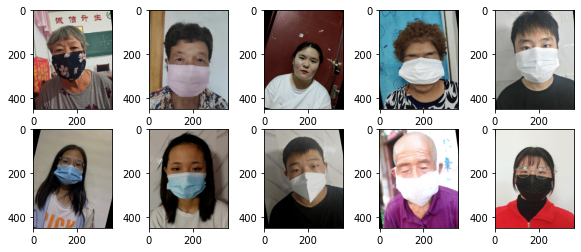

In [48]:
fig = plt.figure(figsize=(10,4))
idx = 0

for i in range(10):
    rand = random.randint(0, len(md))
    img, _ = md[rand]
    img = transform_exp(img)
    idx += 1
    ax = plt.subplot(2, 5, idx)
    plt.imshow(img)